In [1]:
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading datas

In [3]:
train_data_dir = r'/content/drive/My Drive/Courses/DeepLearning/Q1_train.csv'
test_data_dir = r'/content/drive/My Drive/Courses/DeepLearning/Q1_test.csv'
data_train = []
data_test = []
with open(train_data_dir, 'r') as csvfile:
  csvreader = csv.reader(csvfile)
  for row in csvreader:
      data_train.append(row)
with open(test_data_dir, 'r') as csvfile:
  csvreader = csv.reader(csvfile)
  for row in csvreader:
      data_test.append(row)

data_train = np.array(data_train[1:], dtype=np.float32)
data_test = np.array(data_test[1:], dtype=np.float32)

In [23]:
num_of_train_samples = len(data_train[:, 1])
validation_set_size = 0.8
x_train = data_train[0:int(validation_set_size*num_of_train_samples), 1:]
y_train_cls = data_train[0:int(validation_set_size*num_of_train_samples), 0]

x_validation = data_train[int(validation_set_size*num_of_train_samples)+1:, 1:]
y_validation_cls = data_train[int(validation_set_size*num_of_train_samples)+1:, 0]

x_test = data_test[:,1:]
y_test_cls = data_test[:,0]

img_size_flat = len(x_train[0])
img_shape = (int(np.sqrt(img_size_flat)), int(np.sqrt(img_size_flat)))
alphabets =  'ABCDEFGHIKLMNOPQRSTUVWXY'
num_classes = len(alphabets)

$\Large{Part\;a}$ - showing some of the the images

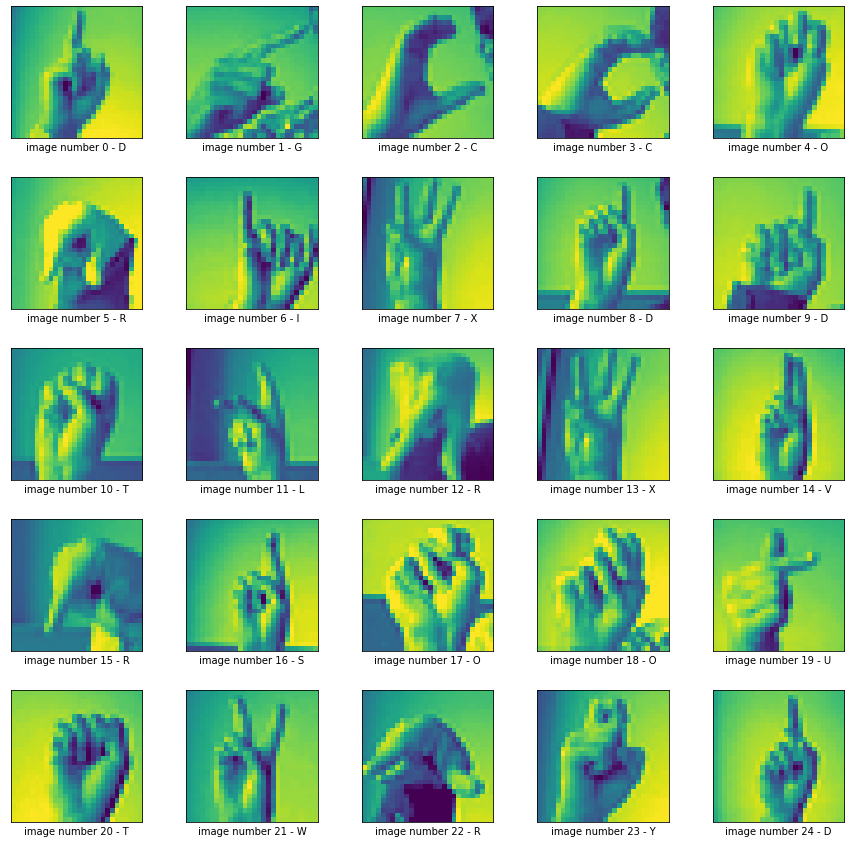

In [13]:
fig, axes = plt.subplots(5, 5, figsize=(15,15))
fig.subplots_adjust(hspace=0.3, wspace=0.3)



for i, ax in enumerate(axes.flat):
    image = x_train[i].reshape(img_shape)

    # Set the label for the sub-plot.
    ax.set_xlabel("image number {0} - ".format(i)+alphabets[int(y_train_cls[i])])

    # Plot the image.
    ax.imshow(image)

    # Remove ticks from each sub-plot.
    ax.set_xticks([])
    ax.set_yticks([])

$\Large{Part\;b}$ - Designing an MLP

In [24]:
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train_cls.reshape(-1, 1)).toarray()
y_test = enc.fit_transform(y_test_cls.reshape(-1, 1)).toarray()
y_validation = enc.fit_transform(y_validation_cls.reshape(-1, 1)).toarray()

## SGD 

In [59]:
tf.reset_default_graph()
# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
# network biases
biases = tf.Variable(tf.zeros([num_classes]))

In [60]:
learning_rate = 0.5
logits = tf.matmul(x, weights) + biases
batch_size = 25
# predicted output
y_pred = tf.nn.softmax(logits)
# predicted classes
y_pred_cls = tf.argmax(y_pred, axis=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate, name='SGD').minimize(cost)

# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [61]:
# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

In [62]:
def optimize(num_iterations):
    accs_train = np.zeros([num_iterations])
    accs_validation = np.zeros([num_iterations])
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        indexes = []
        for j in range(0,batch_size):
          n = random.randint(0,x_train.shape[0]-1)
          indexes.append(n)
        x_batch = x_train[indexes, :]
        x_batch = np.reshape(x_batch, (batch_size, img_size_flat))
        y_true_batch = y_train[indexes]

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict)
        accs_train[i] = calcAccuracy(feed_dict_train)
        accs_validation[i] = calcAccuracy(feed_dict_validation)
    return accs_train, accs_validation 

def calcAccuracy(feed_dict):
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict)
    
    # Print the accuracy.
    # print("Accuracy on test-set: {0:.1%}".format(acc))
    return acc


def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(6, 4, figsize=(15,15))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.

        # Get the weights for the i'th digit and reshape it.
        # Note that w.shape == (img_size_flat, 10)
        image = w[:, i].reshape(img_shape)

        # Set the label for the sub-plot.
        ax.set_xlabel("Weights: {0}".format(i+1))

        # Plot the image.
        ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [63]:
feed_dict_test = {x: x_test,
                  y_true: y_test,
                  y_true_cls: y_test_cls}

feed_dict_train = {x: x_train,
                  y_true: y_train,
                  y_true_cls: y_train_cls}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls}

In [ ]:
num_iterations = 10000
[accs_train, accs_validation] = optimize(num_iterations=num_iterations)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_train, label='Training Error')
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_validation, label='Validation Error')
plt.legend()
plt.show()

plot_weights()

## ADAM

In [40]:
tf.reset_default_graph()
# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
# network biases
biases = tf.Variable(tf.zeros([num_classes]))

In [42]:
learning_rate = 0.5
logits = tf.matmul(x, weights) + biases
batch_size = 50
beta1 = 0.9
beta2 = 0.999
# predicted output
y_pred = tf.nn.softmax(logits)
# predicted classes
y_pred_cls = tf.argmax(y_pred, axis=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=1e-08, name='ADAM'
    ).minimize(cost)

# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [43]:
# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

In [44]:
def optimize(num_iterations):
    accs_train = np.zeros([num_iterations])
    accs_validation = np.zeros([num_iterations])
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        indexes = []
        for j in range(0,batch_size):
          n = random.randint(0,x_train.shape[0]-1)
          indexes.append(n)
        x_batch = x_train[indexes, :]
        x_batch = np.reshape(x_batch, (batch_size, img_size_flat))
        y_true_batch = y_train[indexes]

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict)
        accs_train[i] = calcAccuracy(feed_dict_train)
        accs_validation[i] = calcAccuracy(feed_dict_validation)
    return accs_train, accs_validation 

def calcAccuracy(feed_dict):
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict)
    
    # Print the accuracy.
    # print("Accuracy on test-set: {0:.1%}".format(acc))
    return acc


def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(6, 4, figsize=(15,15))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.

        # Get the weights for the i'th digit and reshape it.
        # Note that w.shape == (img_size_flat, 10)
        image = w[:, i].reshape(img_shape)

        # Set the label for the sub-plot.
        ax.set_xlabel("Weights: {0}".format(i+1))

        # Plot the image.
        ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [45]:
feed_dict_test = {x: x_test,
                  y_true: y_test,
                  y_true_cls: y_test_cls}

feed_dict_train = {x: x_train,
                  y_true: y_train,
                  y_true_cls: y_train_cls}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls}

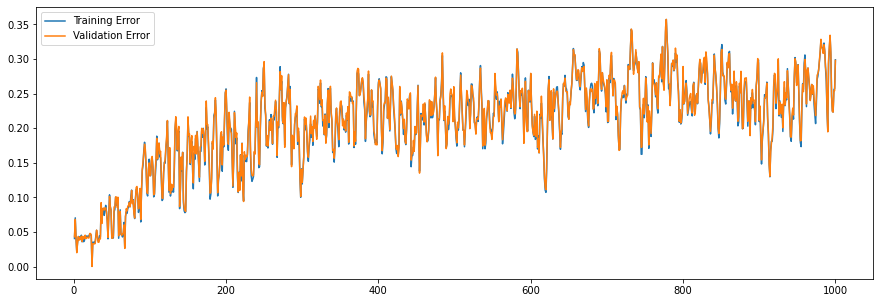

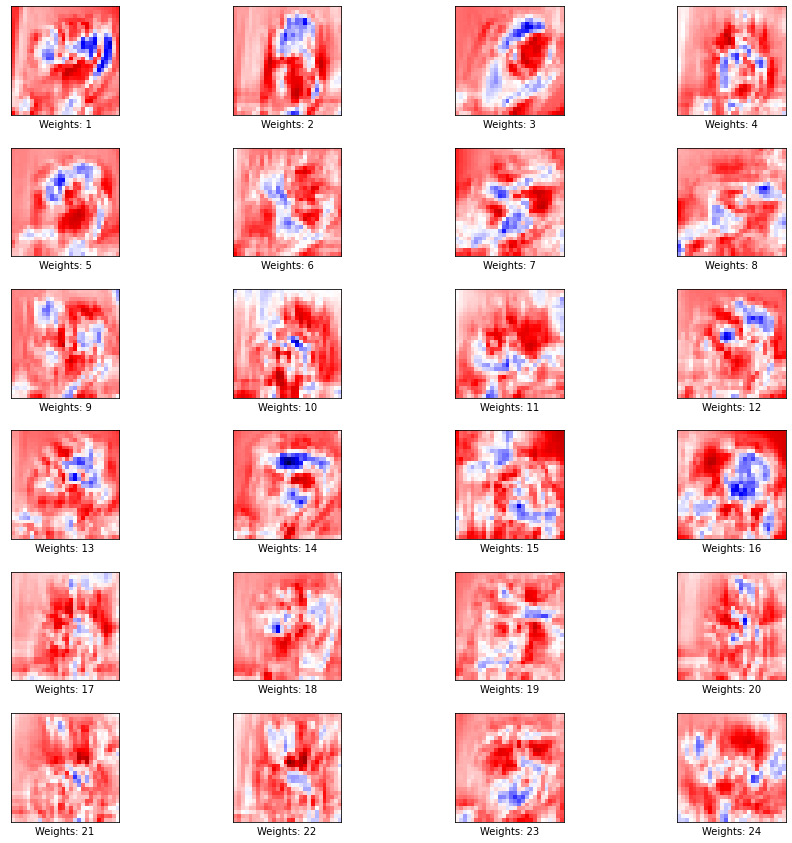

In [46]:
num_iterations = 1000
[accs_train, accs_validation] = optimize(num_iterations=num_iterations)

fig, axes = plt.subplots(1, 1, figsize=(15,5))
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_train, label='Training Error')
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_validation, label='Validation Error')
plt.legend()
plt.show()

plot_weights()